# Project 4: Applying DNN to the indoor location problem using Wi-Fi coverage

## 1. Introduction

In this exercise, we are going to apply a Deep Neural Network (DNN), which we covered in the previous project, to a real-world problem. This problem consists of using the strength of the Wi-Fi signal received (Received Signal Strength Indication - RSSI) by a cellular device to determine its position within an environment.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import erfc, erfcinv
from scipy.integrate import quad
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os

%matplotlib inline

Before we start implementing the actual code, let's check if there are any GPUs available to run the codes, with the aim of speeding up the training of the DNN.

In [2]:
train_on_gpu = torch.cuda.is_available()  
if train_on_gpu:
    device = torch.device("cuda")  
    print("Training on GPU.")
else:
    device = torch.device("cpu")
    print("GPU unavailable, training on CPU.")

Training on GPU.


## 3. Description of the problem

As previously indicated, we will be using a DNN to address the problem of localization in indoor environments, covering places such as homes, apartments, buildings and industrial facilities. In this context, we will be focusing our analysis on a specific floor of a building, which contains multiple rooms. For a better visualization, the image below shows the configuration of the rooms on that floor.

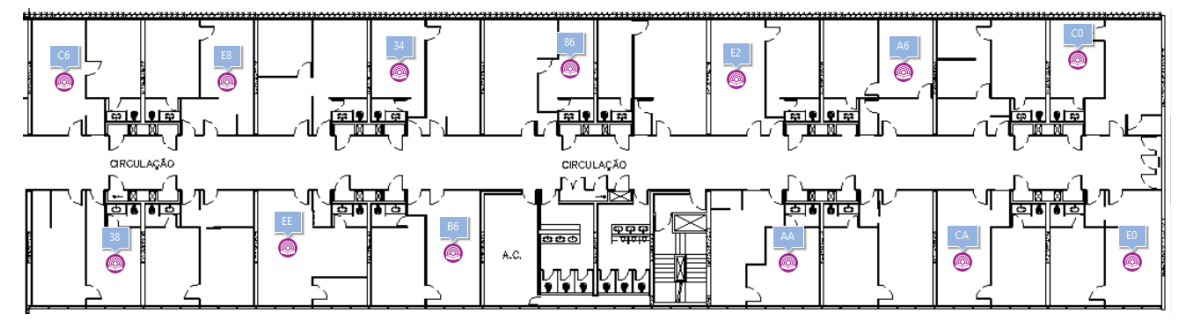

In addition, the image above also illustrates, in pink, where each Access Point (AP), the device responsible for transmitting the Wi-Fi signal, is in the room. In all, the floor has 13 APs and an area of approximately 1215 m². The APs are fixed to the ceiling, at a height of approximately 2.1 meters.

With the scenario established, we need to collect the power information received by the user devices (User Equipment - UE) at different points in the environment to compose the dataset that will allow us to train and test the DNN. To do this, we carried out a passive survey of the environment, collecting power from each of the 13 APs at various points in the scenario.

To build the dataset, we used a dedicated device to collect power information, also known as RSSI, from the Wi-Fi signal. When this device is connected to a computer, it transfers all the measurements, as well as the coordinates of the analysis point, to a text file in CSV format. The file will then contain information on the power of the 13 access points (APs) at each of the data collection points, along with the respective coordinates of these points in the environment.

The points at which the power of the 13 APs was collected are illustrated below:

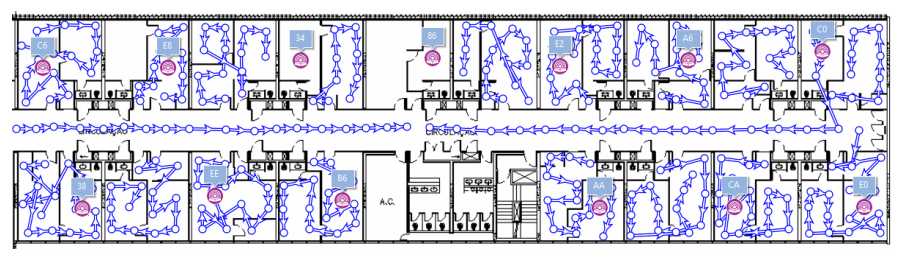

In the image above, each circle refers to an RSSI collection point. In all, we collected the information described above for 522 points.

## 4. Problem's DNN

Now, let's define the DNN that we will use in our application. As discussed in the previous project, we will use the `PyTorch` library in order to simplify and speed up the creation of the model. We will therefore start by importing PyTorch into the code.

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Set random seed for reproducibility
seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

### 4.1 Model creation

As described, the data set we have collected includes the coordinates of the point under analysis, along with the powers of the 13 APs present on the floor in question. Our main objective is to use this power information from the 13 APs at a specific point to estimate the coordinates of that point. To accomplish this task, we will configure our neural network with 13 input units, where each input represents the RSSI of one of the APs at a given data collection point, and 2 output units, which represent the coordinates (x, y) of that point.

Now that we have defined the number of units for the input and output of our network, the next step is to determine how many hidden layers and how many neurons we will have in each of these layers. It's important to remember that by adjusting these quantities, we are influencing the capacity of the learning network. Generally, our goal is to find the most optimized configuration of the network, i.e. the one that requires the least number of neurons and hidden layers to achieve good accuracy, since more units and layers result in a greater computational burden.

For our application, we will start with two hidden layers with 200 units each, and we want to obtain very accurate results. Our job is to determine the smallest number of neurons per layer that leads to the desired results, which will be presented at the end of the notebook. To do this, we will keep the number of layers unchanged, as well as, of course, the number of neurons in the input and output layers.

The structure of our neural network will be detailed below, in which we have an input layer, two hidden layers and an output layer. We will now build this network using PyTorch. Its structure is as follows:

- An input layer with Linear activation function with:

        -> Input: 13
        -> Output: 200
        -> Bias: True
    
- A hidden layer with ReLu activation function with:

        -> Input: 200
        -> Output: 200
        -> Bias: True

- A hidden layer with ReLu activation function with:

        -> Input: 200
        -> Output: 2
        -> Bias: True
    
- And the output layer, also with ReLu activation function, which contains the outputs with the coordinates of the analyzed point, thus two units.

We will therefore build our neural network from the NeuralNetwork class. This class is initialized by defining the functions `fc1`, `fc2` and `fc3` which perform linear transformations on the data in each layer, the first of which occurs in the input layer (with 13 inputs and 200 outputs), the second in the hidden layer (with 200 inputs and 200 outputs) and the third, also in the hidden layer (with 200 inputs and 2 outputs).

Next, we'll define the forward() function which executes the ReLu function as the activation functions for the layers in question.

Next, we will define the forward() function, which is responsible for receiving the input and passing it through the neurons to generate an output, using the ReLU function as the activation functions at the output of the three layers in question.

The ReLU (Rectified Linear Unit) activation function is one of the most widely used activation functions in artificial neural networks and deep learning. It is known for its simplicity and effectiveness in solving machine learning and information processing problems.

The ReLU function returns the input value if this value is greater than zero and returns zero if the value is less than or equal to zero. Therefore, the function is linear for positive values and returns zero for negative values.

The main reason why the ReLU function is widely used is because of its ability to overcome the problem of low gradient values, which is common with certain activation functions, such as the sigmoid and the hyperbolic tangent. This is because the derivative of the ReLU function is simple to calculate and does not approach zero in most of its domain, allowing for effective gradient values when training deep neural networks.

In addition, the ReLU function is computationally efficient and quick to calculate, which makes it a practical choice in modern deep neural networks. However, it is important to note that the ReLU function can lead to the neural network having some inactive neurons (i.e. always returning zero) and not updating its weights during training. To combat this problem, variants of the ReLU function, such as Leaky ReLU and Exponential Linear Unit (ELU), have been introduced. If you would like to try another activation function, feel free to do so. See the literature for some interesting examples. But remember that the activation function in the output layer must be suitable for the desired result. In our case, ReLu has this property. Think about it for a moment.

In summary, the ReLU activation function, whose graph is illustrated below, is a cornerstone in deep neural networks due to its effectiveness, computational efficiency and ability to overcome the problem of vanishing gradients.

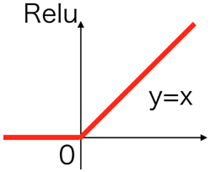

In [5]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=13, out_features=200, bias=True)
        self.fc2 = torch.nn.Linear(in_features=200, out_features=200, bias=True)
        self.fc3 = torch.nn.Linear(in_features=200, out_features=2, bias=True)

    def forward(self, out):
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        return out

### 4.2 Processing and treatment of input data

When we are building a machine learning model, we need to estimate how suitable it is, based on some metric. In addition, this quality test should be carried out on data that was not used to train the model, so that we can measure the model's ability to generalize by observing the model's behaviour when it receives data that has never been seen before.

For this reason, we recommend dividing our data into three parts, all with a specific objective. These are:

- **Training:** In a nutshell, this is the portion of the data that will be used to adjust the model. In other words, it's the data that will be used to train the model, adjusting the values of the weights of each edge by inserting this data.

- **Validation:** This is the portion of the data used to provide an unbiased assessment, since this data will not be used to adjust the parameters, measuring the network's ability to generalize. This set is used to check whether adjustments need to be made to the network's training process. Validation is used to check that the trained model is not overfitting.

- **Test:** This is the portion of the data used to evaluate the model at the end of all the training, without the intention of adjusting any more points in the model. We then use the test data when we want to predict new results for our model.

But what is overfitting? There are two scenarios that are possible, but not desirable, when training a network: overfitting and underfitting.

Overfitting is a scenario where the model performs excellently on the training data, but fails to repeat this performance on the validation data. We can understand that, in this case, the model has learned the relationships existing in the training data so well that it has simply memorized what should be done in these cases, so that when it receives the information it hasn't seen yet, the model is unable to generalize and ends up trying to apply the same memorized rules which end up not working, affecting its performance.

Underfitting is another scenario where the model's performance converges very slowly in the training itself, so that the learning process ends and the model is unable to find relationships between the variables.

The image below shows three behaviors, one where overfitting occurs, another is what we are looking for when we train the network and the last is the case where underfitting occurs.

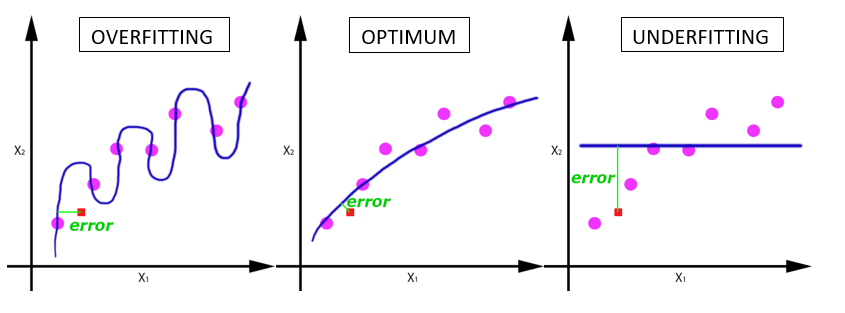

Due to the small amount of data collected, we will separate the dataset into training data and another part for validation and testing. We will now import the dataset, which is the CSV file generated after the survey. After reading it, we will perform a shuffle operation on the position data in order to eliminate any influence caused by the original sequence.

In [6]:
df = pd.read_csv(os.path.join("dataset/", "rssi-dataset.csv"))
df = df.iloc[:, 1:]
df = df.sample(frac=1)

Before we continue, let's take a look at how the dataset is organized below.

In [7]:
df.head()

,X,Y,2c5741f10e01,2c5741f11ca1,2c5741f11aa1,2c5741f0eb61,2c5741f29ee1,2c5741f5f381,2c5741f58c61,2c5741f0ee81,2c5741f0e341,2c5741f5d861,2c5741f5de21,2c5741f0fa61,2c5741f0ec01
171,156.824571,65.700286,-100,-100,-100,-79,-52,-70,-74,-53,-75,-100,-100,-100,-100
477,198.138571,69.462000,-74,-100,-57,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
104,170.509429,60.965714,-100,-100,-100,-56,-100,-100,-100,-81,-61,-56,-100,-100,-100
351,186.269714,58.176857,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-51,-82,-100
504,205.078286,65.959714,-65,-45,-80,-100,-100,-100,-100,-100,-100,-100,-100,-71,-73


You can see that, for each coordinate pair (x,y), we have power information for each of the 13 APs. The power value collected is in dBm, which is a unit of measurement that expresses absolute power through a logarithmic relationship (in decibels) based on 1 mW. In other words, 0 dBm equals 1 mW. Therefore, the higher its value, the closer the AP is physically to the point being analyzed. Note that there are many points where the power is `-100 dBm`. Right?

**There's an explanation for that!**

Due to the extremely large size of the building floor, when a collection point is very far from an AP, the RSSI value is so small that the measurement equipment is unable to collect power information (RSSI) from that AP at that point. To deal with these cases, we implemented data pre-processing, where we set a value of `-100 dBm` whenever we were unable to collect power information. This approach aims to help the network recognize that these powers share a common characteristic, i.e. they indicate that the AP is far from the point in question.

Once the structure of the neural network has been created, we need to process the input data, adapting it to a format in which the class we created can process it to learn the network's parameters.

As the data has already been imported, we will transform it into tensors before creating the dataset. To do this, we'll use the torch.Tensor() and torch.LongTensor() methods. The difference between the two is that the former accepts values of type float (specifically float32) while the latter accepts values of type int (specifically int64).

In addition, we're going to divide this data into two separate sets: a test set and a training set. Since we've already shuffled the data during the import, we now just need to determine the proportion of data destined for each of the sets.

In [8]:
test_proportion = 15

An additional treatment we carry out, depending on the problem, is the normalization of the network's input data. Normalization is an essential process to ensure that all the characteristics of the input data are on the same scale. This is important because, in many machine learning algorithms, features with different scales can negatively affect the model's performance. Normalizing the data involves adjusting the scales to a common range, usually between 0 and 1 or -1 and 1, so that all the features contribute equally to the learning process. This helps the neural network to converge more quickly and to avoid problems such as the predominance of high-scale features over low-scale ones.

To normalize the data, the average of each feature is usually subtracted and divided by the standard deviation. This is known as Z-score normalization. Another common approach is Min-Max normalization, where the values are scaled to a specific interval, such as [0, 1].

The choice between these methods depends on the specific problem and the distribution of your data. Normalization is an important data pre-processing step for neural networks, as it can significantly improve model performance and help avoid convergence problems.

In the context of our problem, we chose to use Min-Max normalization to prepare our data. Now we need to implement the function responsible for performing this normalization on the input data.

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(0, 1))


def min_max_scaler(input):
    scaler.fit(input)
    return scaler.transform(input)

Finally, let's process and separate the dataset.

In [10]:
# Determining the number of test samples based on a given test proportion
test_num = int(test_proportion / 100 * len(df))

# Splitting input and output data into training and testing sets
# Converting the data to float32 data type
input_train, input_test = (
    df.iloc[:-test_num, 2:].astype(np.float32).values,
    df.iloc[-test_num:, 2:].astype(np.float32).values,
)
output_train, output_test = (
    df.iloc[:-test_num, 0:2].astype(np.float32).values,
    df.iloc[-test_num:, 0:2].astype(np.float32).values,
)

# Scaling the input data using a scaler (Min-Max)
input_train = min_max_scaler(input_train)
input_test = min_max_scaler(input_test)

# Converting the scaled data into PyTorch tensors
input_train, input_test = torch.Tensor(input_train), torch.Tensor(input_test)
output_train, output_test = torch.Tensor(output_train), torch.Tensor(output_test)

Once this is done, we can create our dataset which will be used to train the neural network. To do this, we'll use the TensorDataset and DataLoader functions. But first we need to define the batch size. We started by using an initial value of 50, but by experimenting with other values, we chose one that allows for an adequate optimization process. In these functions, we will select the desired batch size, as well as the option to shuffle the data to improve the performance of the neural network.

In [11]:
# Batch Size
batch_size = 16

# Creating datasets using the input and output tensors
dataset_train = TensorDataset(input_train, output_train)  # Training dataset
dataset_valid = TensorDataset(input_test, output_test)  # Validation dataset

# Creating data loaders for training and testing with specified batch sizes
dataloader_train = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)  # Training data loader
dataloader_test = DataLoader(
    dataset_valid, batch_size=test_num, shuffle=True
)  # Testing data loader

### 4.3 DNN Training and Validation

To train the neural network, it is necessary to choose which cost function will be used and which algorithm will optimize the network parameters.

PyTorch provides several types of cost function within the `torch.nn` module. Among the best known are *Cross Entropy* and *mean squared error*. As for the optimization algorithm, the library also provides several types, among the best known are *Gradient Descent*, *Stochastic Gradient Descent* and *Adam*.

In our program, we chose *Mean Squared Error* for the cost function and, as the optimization algorithm, we chose *Adam* with initial values of *learning rate* of 0.5 and, for the other values of the optimizer, we used the default values of the algorithm implemented in Pytorch. Through experimentation, we adjusted the values of the important parameters of the optimizer accordingly. With everything configured, we can instantiate our neural network in the `model` variable

In [12]:
# Instantiate the NN into variable model
model = NeuralNetwork()

# Definition of cost function
criterion = torch.nn.MSELoss()

# Definition of ADAM as optimizer algorithm and its parameter sets
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

We will print the `model` variable so that we can see its details.

In [13]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=13, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)


Once the training data has been processed correctly and the model has been properly instantiated with the cost function and optimization algorithm configured, we must build the network's training loop. We will first choose the number of epochs that our neural network will go through in this training stage. In each of these epochs, the neural network must create another loop in which each example of the dataloader will be explored, calculating the error and optimizing the parameters at the end of each of these examples. Note that we have two loops, one for training the network and the other for testing the network during training with the validation data.

In [14]:
# number of epochs to train the model
epochs = 400

train_losses, valid_losses = [], []
test = float("inf")

for e in range(epochs):

    correct, total = 0, 0
    train_loss, valid_loss = 0, 0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for RSSI, position in dataloader_train:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(RSSI)
        # calculate the loss
        loss = criterion(output, position)
        # backward pass: compute gradient of the loss with respect to model parameters)
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
    ######################
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for RSSI, position in dataloader_test:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(RSSI)
        # calculate the loss
        loss = criterion(output, position)
        # update running validation loss
        valid_loss += loss.item()
        torch.save(model.state_dict(), "model")
    else:
        train_loss = train_loss / len(dataloader_train)
        valid_loss = valid_loss / len(dataloader_test)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        if e % 5 == 0:
            print(
                "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                    e + 1, train_loss, valid_loss
                )
            )

Epoch: 1 	Training Loss: 12184.768860 	Validation Loss: 1697.852173
Epoch: 6 	Training Loss: 129.761380 	Validation Loss: 230.158310
Epoch: 11 	Training Loss: 39.644759 	Validation Loss: 49.018185
Epoch: 16 	Training Loss: 19.313102 	Validation Loss: 26.199730
Epoch: 21 	Training Loss: 13.019823 	Validation Loss: 19.909367
Epoch: 26 	Training Loss: 9.487576 	Validation Loss: 13.346846
Epoch: 31 	Training Loss: 7.987910 	Validation Loss: 16.395815
Epoch: 36 	Training Loss: 7.837625 	Validation Loss: 11.218488
Epoch: 41 	Training Loss: 6.829995 	Validation Loss: 10.185528
Epoch: 46 	Training Loss: 6.813305 	Validation Loss: 8.572820
Epoch: 51 	Training Loss: 6.802054 	Validation Loss: 9.293406
Epoch: 56 	Training Loss: 6.159718 	Validation Loss: 7.834552
Epoch: 61 	Training Loss: 5.766123 	Validation Loss: 7.348647
Epoch: 66 	Training Loss: 6.466472 	Validation Loss: 8.662628
Epoch: 71 	Training Loss: 5.552813 	Validation Loss: 6.507819
Epoch: 76 	Training Loss: 5.334227 	Validation Loss

Note that throughout the training process, we have the ability to monitor the error in the training data and the test data. This practice is fundamental, as it allows us to assess whether the model is converging properly. The ideal scenario is one in which both the training error and the validation error decrease each time. With the network trained, we can plot the values of the cost function as a function of the number of epochs, so that we can analyze its behavior and see if the expected convergence has occurred. The cells below will plot the graphs with the training and validation loss function, respectively.

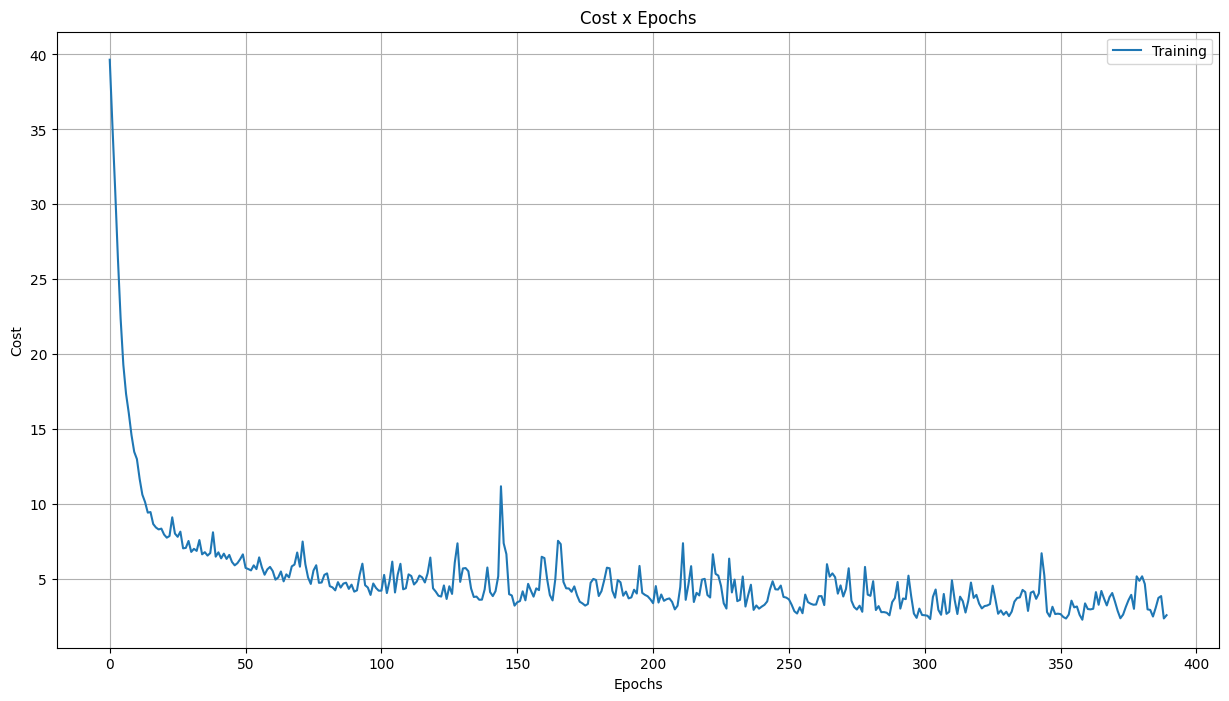

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(train_losses[10:], label="Training")
plt.title("Cost x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid(True)
plt.legend()
plt.show()

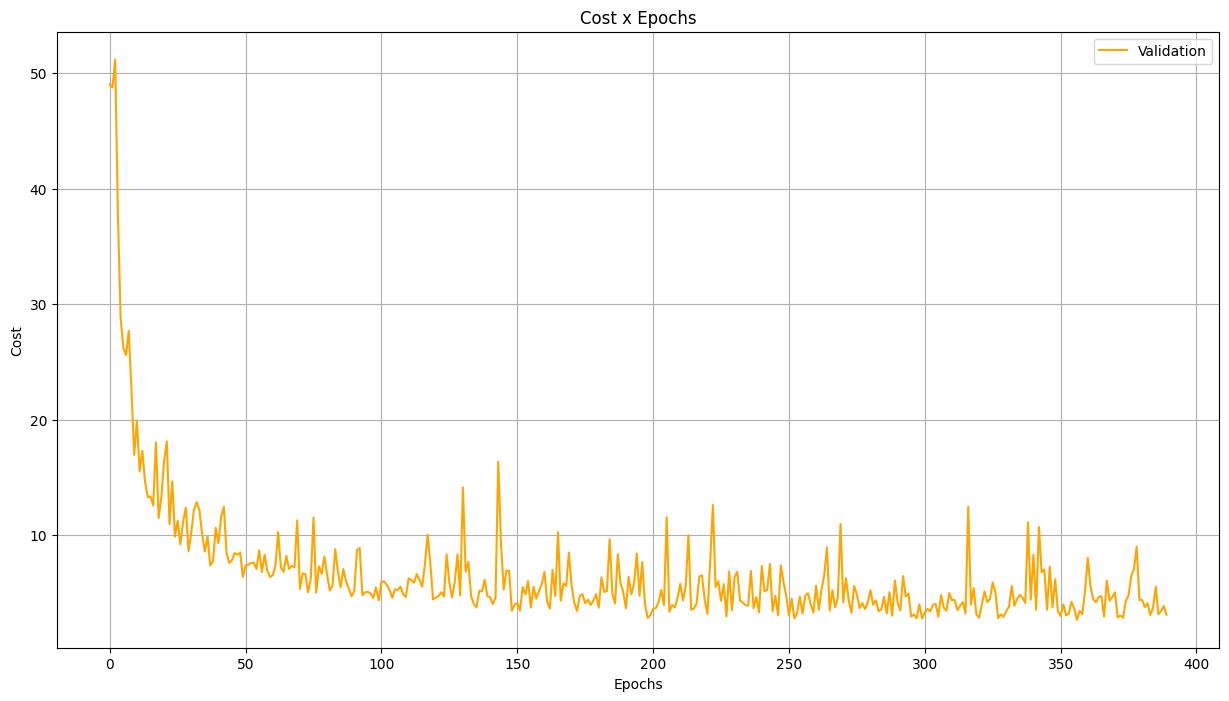

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(valid_losses[10:], label="Validation", color="orange")
plt.title("Cost x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid(True)
plt.legend()
plt.show()

The cell below will plot the two graphs (of the training loss function and the validation loss function).

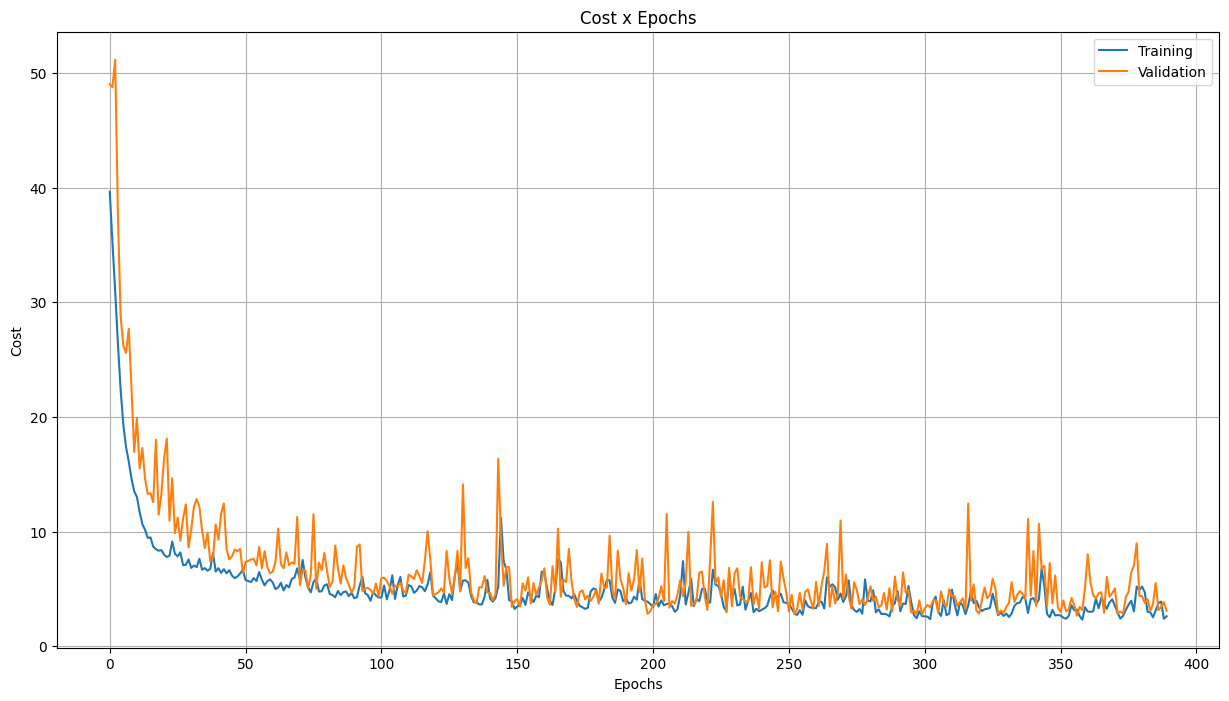

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(train_losses[10:], label="Training")
plt.plot(valid_losses[10:], label="Validation")
plt.title("Cost x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid(True)
plt.legend()
plt.show()

It is important to note that, when analyzing our data set, we faced notable challenges related to training and validation errors. To improve visualization of the evolution of training and validation errors and avoid distorting our analysis, we chose not to plot the first 10 errors.

Furthermore, when comparing the raw errors between the two sets, we noticed a substantial difference in the scale of the error. This discrepancy is a direct consequence of the number of records present in each data set. The training data contains considerably more samples compared to the validation data, which naturally results in larger total errors in the training set. However, it is important to note that this scale of error should not be interpreted as a direct measure of the performance of the model itself, since it is intrinsically related to the size of the training set. It is therefore crucial to adopt a more granular approach, considering the average error per sample, in order to carry out a more accurate and meaningful analysis of the model's performance on both sets of data.

It is known that the choice of the number of training epochs is fundamental to obtaining an adequately performing network. We therefore encourage you to vary the number of epochs in order to choose a value that is suitable for the network's training process.

### 4.4 Testing the Trained Network

As already mentioned, the trained network must be tested with data that does not belong to the training set. As we have already separated the validation data, we will use it to carry out the tests. To carry out the test, you need to load the network model that was previously trained. After importing the model, the next step is to use it to make predictions based on the validation data. So your task is to import the trained model and carry out the evaluation using the test data.

In [18]:
# Instantiate the NN into variable model_teste
model_test = NeuralNetwork()

# Load a pre-trained model from a file named 'model'
model_test.load_state_dict(torch.load("model", map_location=torch.device("cpu")))

# Prepare the model for evaluation mode (turn off dropout, etc.)
model_test.eval()

# Create an empty list to store the model's output
output_test = []

# Iterate through the test dataloader, which provides RSSI data and positions
for RSSI, positions in dataloader_test:
    with torch.no_grad():
        pred = model(RSSI)
        output_test = pred

/tmp/ipykernel_59596/3491785419.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load("model", map_location=torch.device("cpu")))


To assess the accuracy of our model, we will use the
RMSE (Root Mean Square Error), which is a metric commonly used to evaluate the performance of regression or prediction models in machine learning tasks. RMSE measures the difference between the values predicted by the model and the actual data values. It is a measure of the square root of the mean of the squares of the differences between the predicted values and the observed values.

Since the `sklearn` library already offers this function, we'll use it.

In [19]:
from sklearn.metrics import root_mean_squared_error

RMSE_x = root_mean_squared_error(output_test[:, 0].tolist(), positions[:, 0].tolist())
RMSE_y = root_mean_squared_error(output_test[:, 1].tolist(), positions[:, 1].tolist())

Now, let's visualize the errors.

In [20]:
print(
    "Root Mean Square Error (RMSE) X-axis: {:.6f} \nResolution Mean Square Error (RMSE) Y-axis: {:.6f}".format(
        RMSE_x, RMSE_y
    )
)

Root Mean Square Error (RMSE) X-axis: 1.816139 
Resolution Mean Square Error (RMSE) Y-axis: 1.700156


Notice that we have two different errors, one for each coordinate. Because the x-axis of the floor is longer, it is natural that we have a larger error in this dimension. For a more comprehensive understanding, we can consolidate these errors into a single measure of distance error. In this way, the error is:

In [21]:
import math

print("Root Mean Square Error (RMSE): {:.6f}".format(math.sqrt(RMSE_x**2 + RMSE_y**2)))

Root Mean Square Error (RMSE): 2.487748


Once we have obtained the error from the neural network, we can go on to analyze this error in more detail and create a Cumulative Distribution Function (CDF) graph. The CDF provides us with a way of visualizing and understanding the distribution of the error. Let's first obtain the overall error, other than by coordinate, for each of the test points.

In [22]:
errors = []
for i in range(len(output_test[:, 0].tolist())):
    x = output_test[:, 0].tolist()[i] - positions[:, 0].tolist()[i]
    y = output_test[:, 1].tolist()[i] - positions[:, 1].tolist()[i]
    error = math.sqrt(x**2 + y**2)
    errors.append(error)

Now let's plot the CDF:

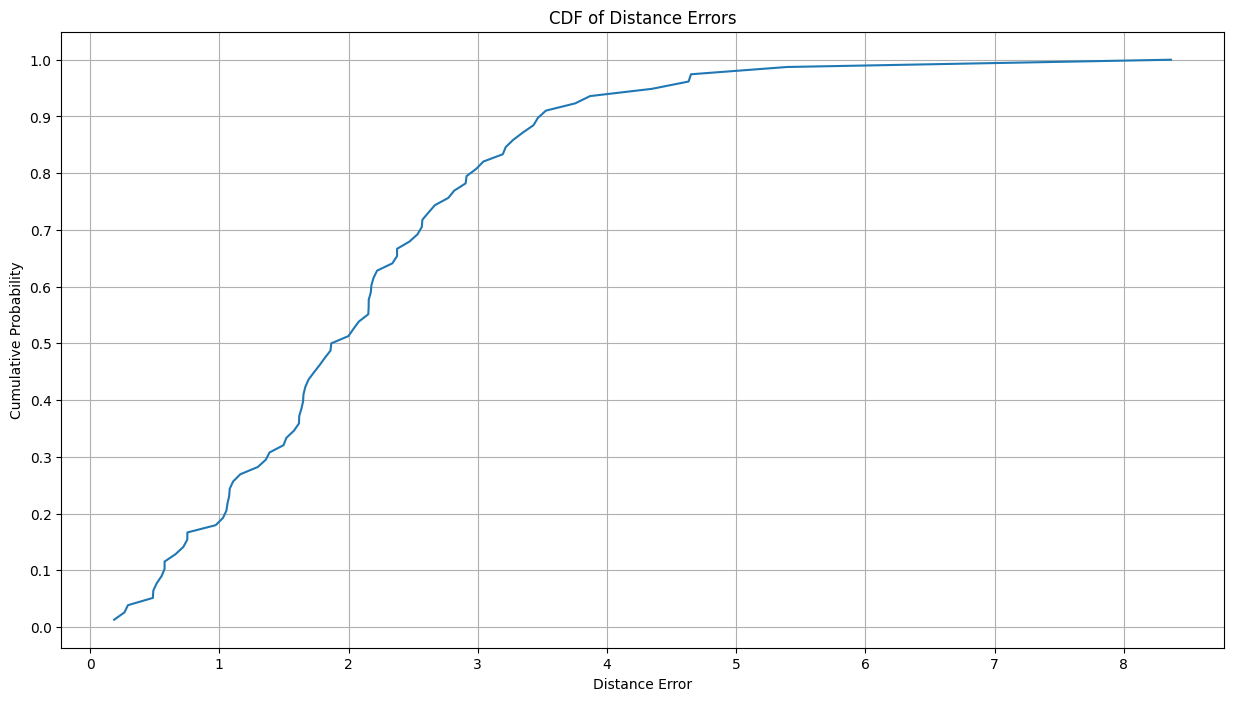

In [23]:
# Classify errors
sorted_errors = np.sort(errors)

# calculate the CDF
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot the CDF with a solid line
plt.figure(figsize=(15, 8))
plt.plot(sorted_errors, cdf)
plt.xlabel("Distance Error")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Distance Errors")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

From the CDF it is possible to determine the percentage of errors that are below a certain value.